<style>
img {
    width: 100%;
    padding-left: 0%;
}
</style>

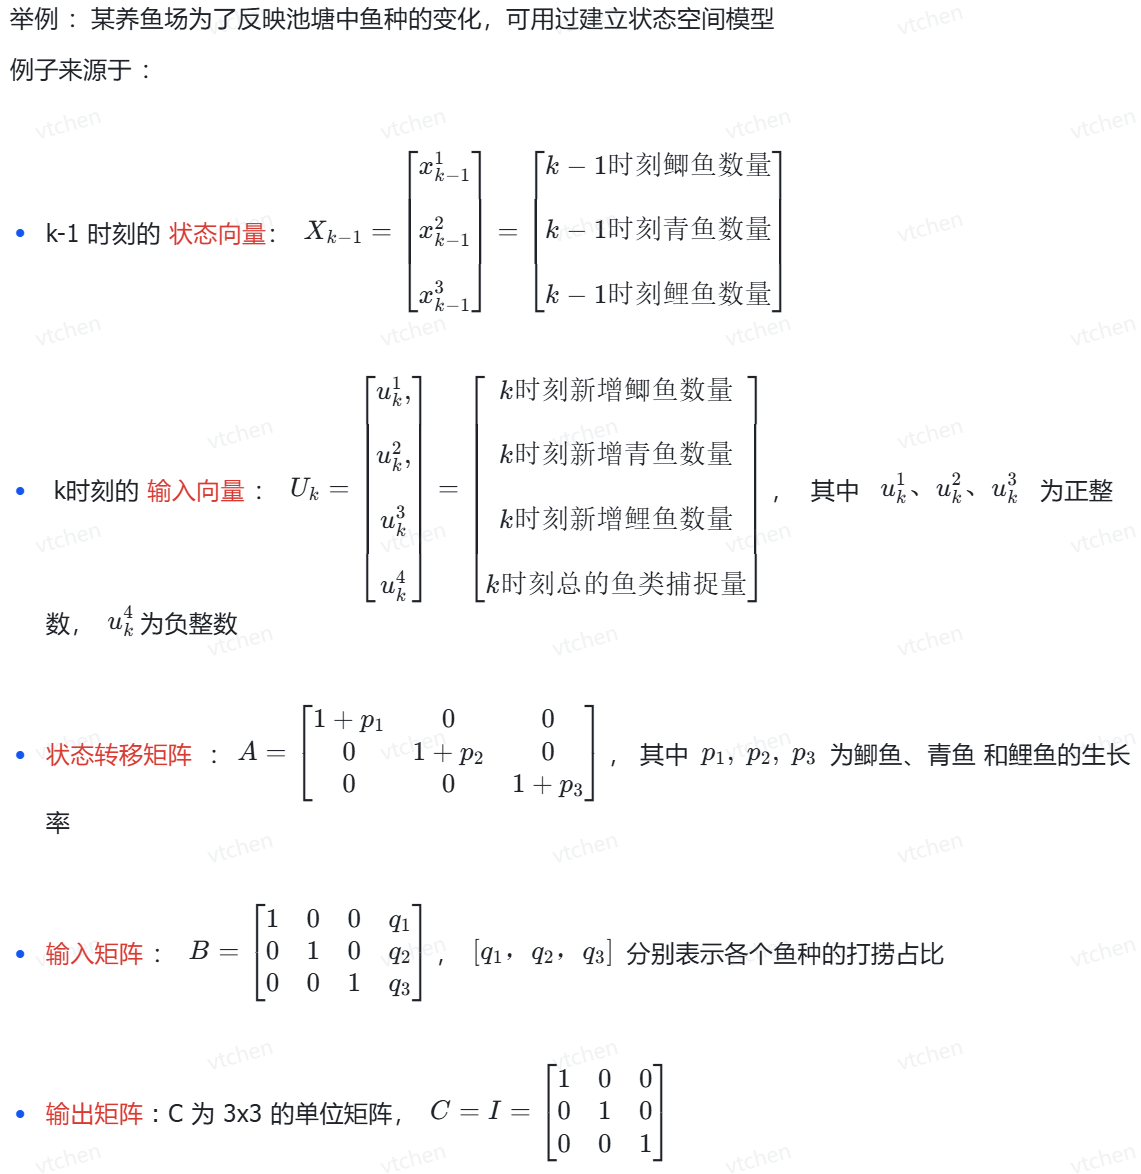
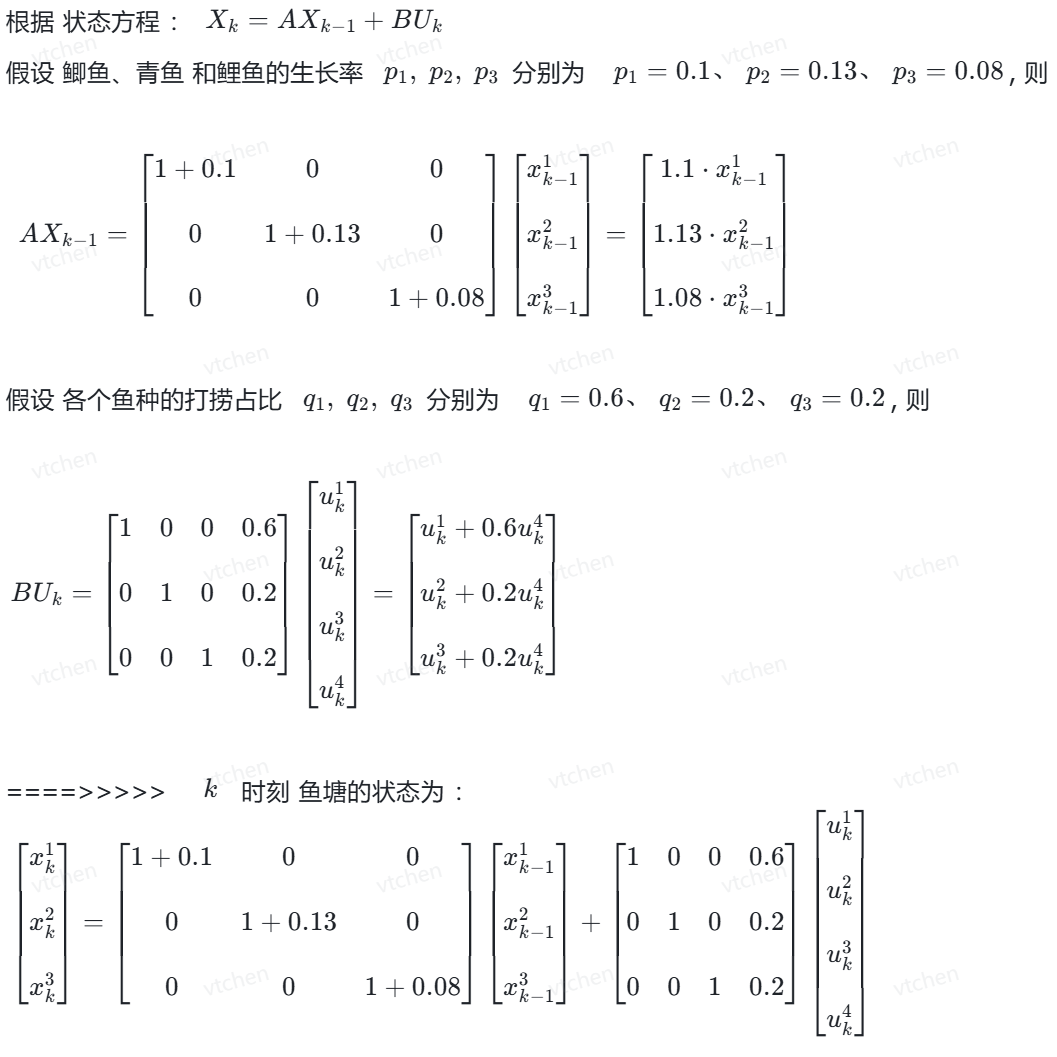
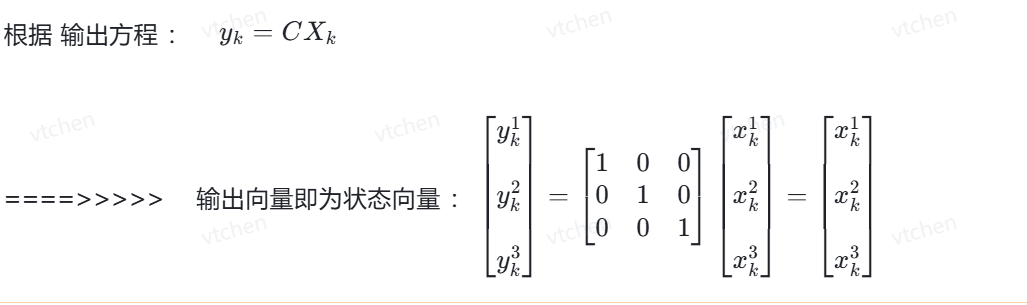

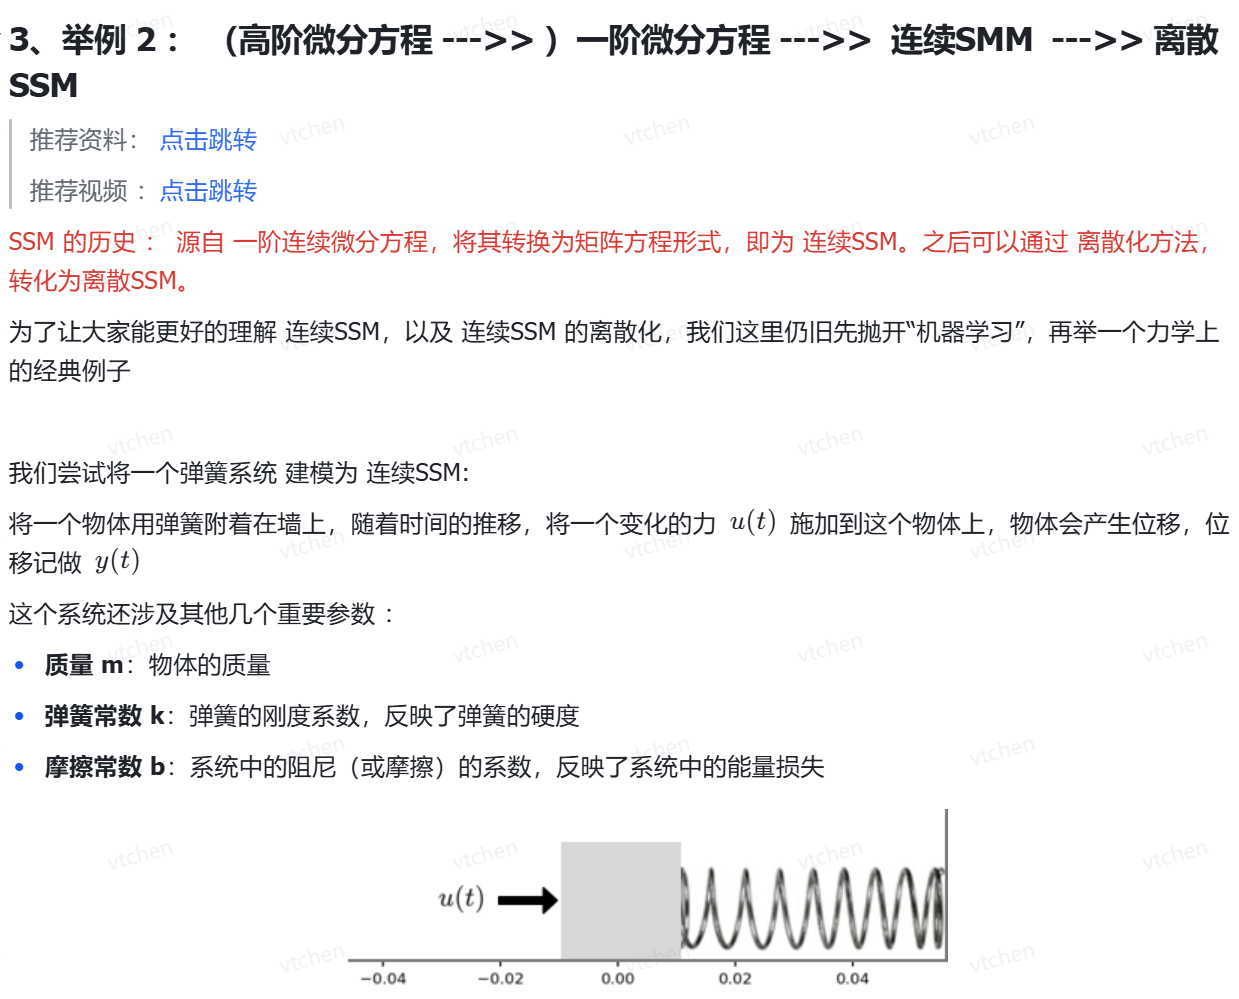
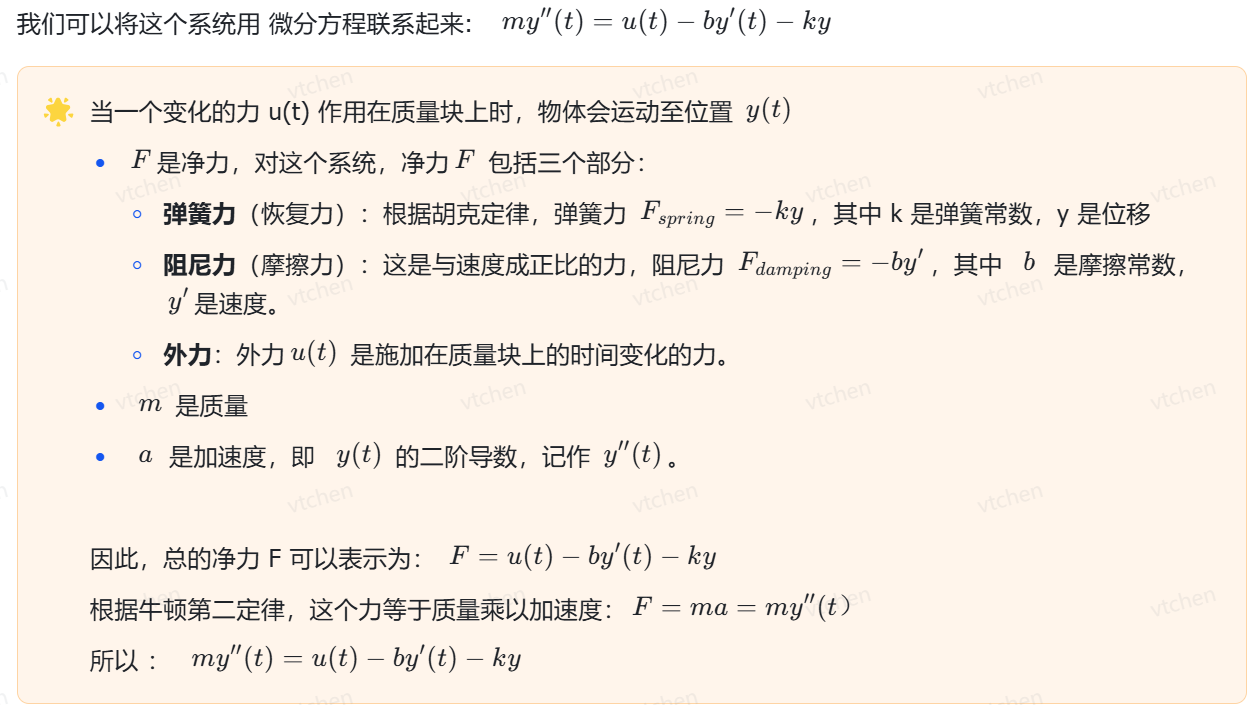
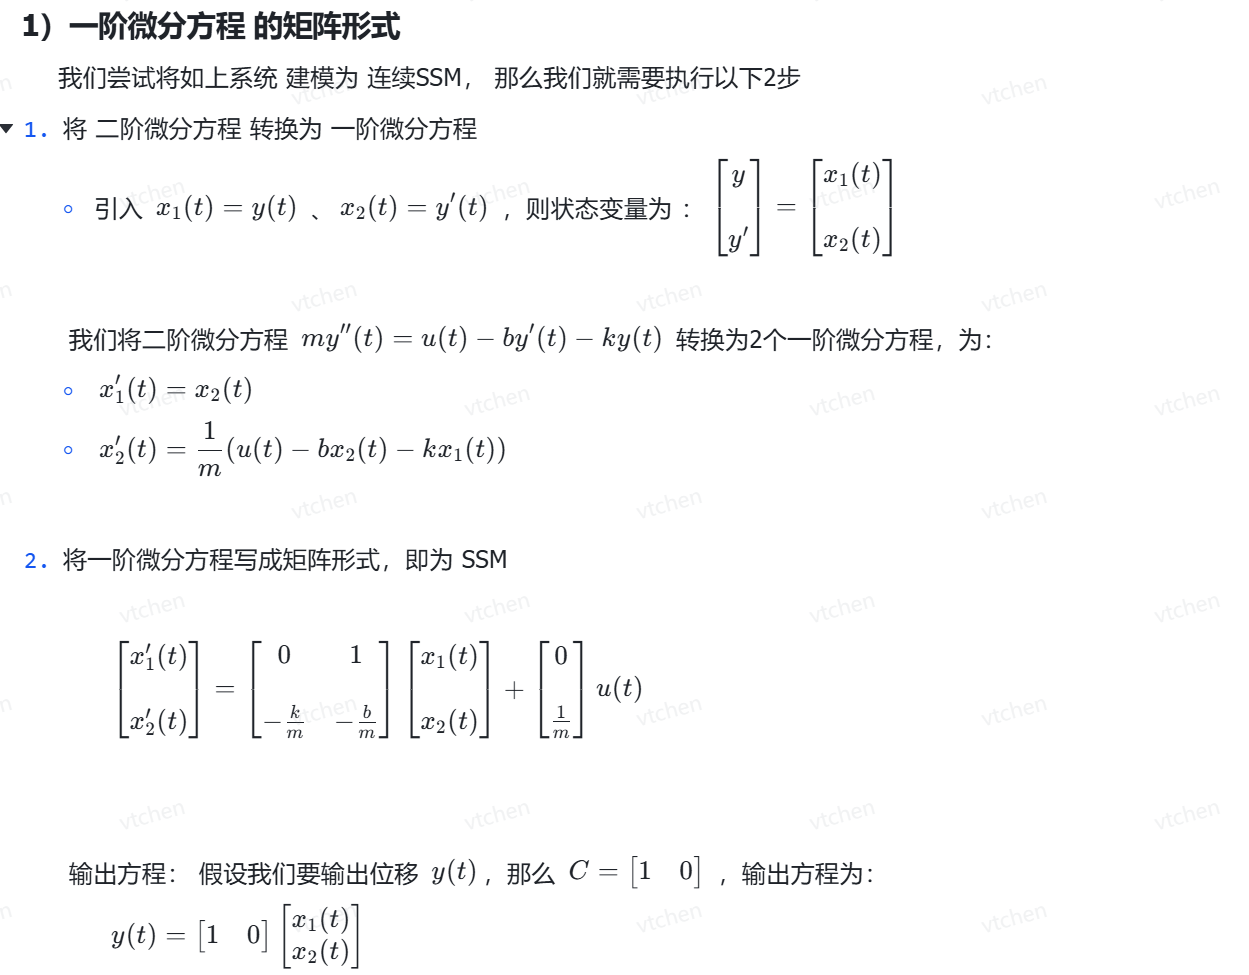
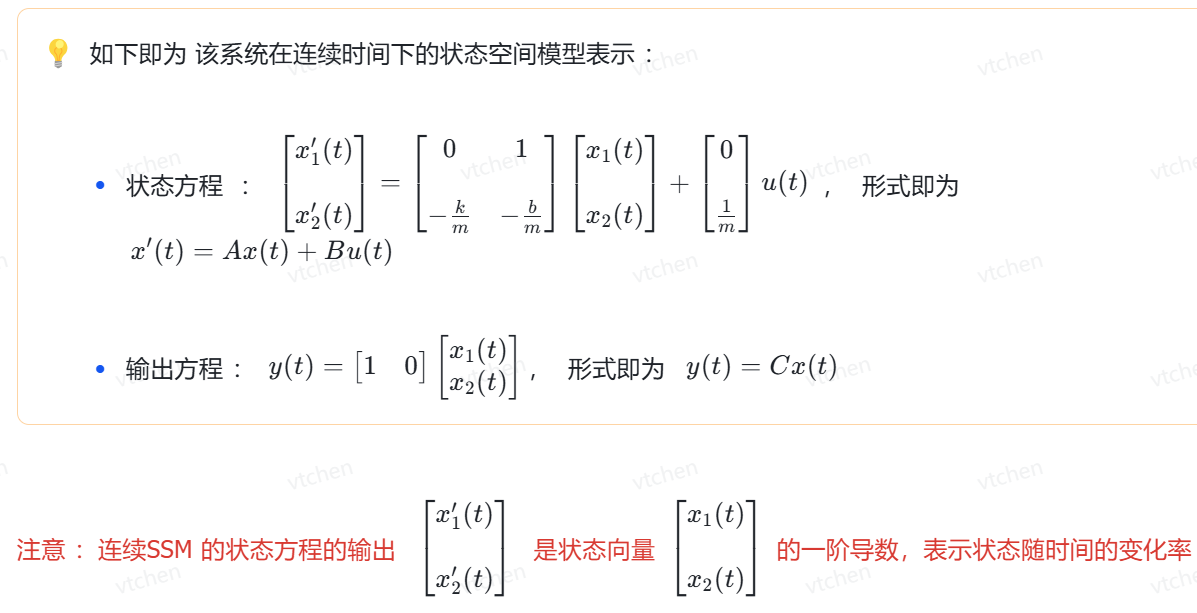

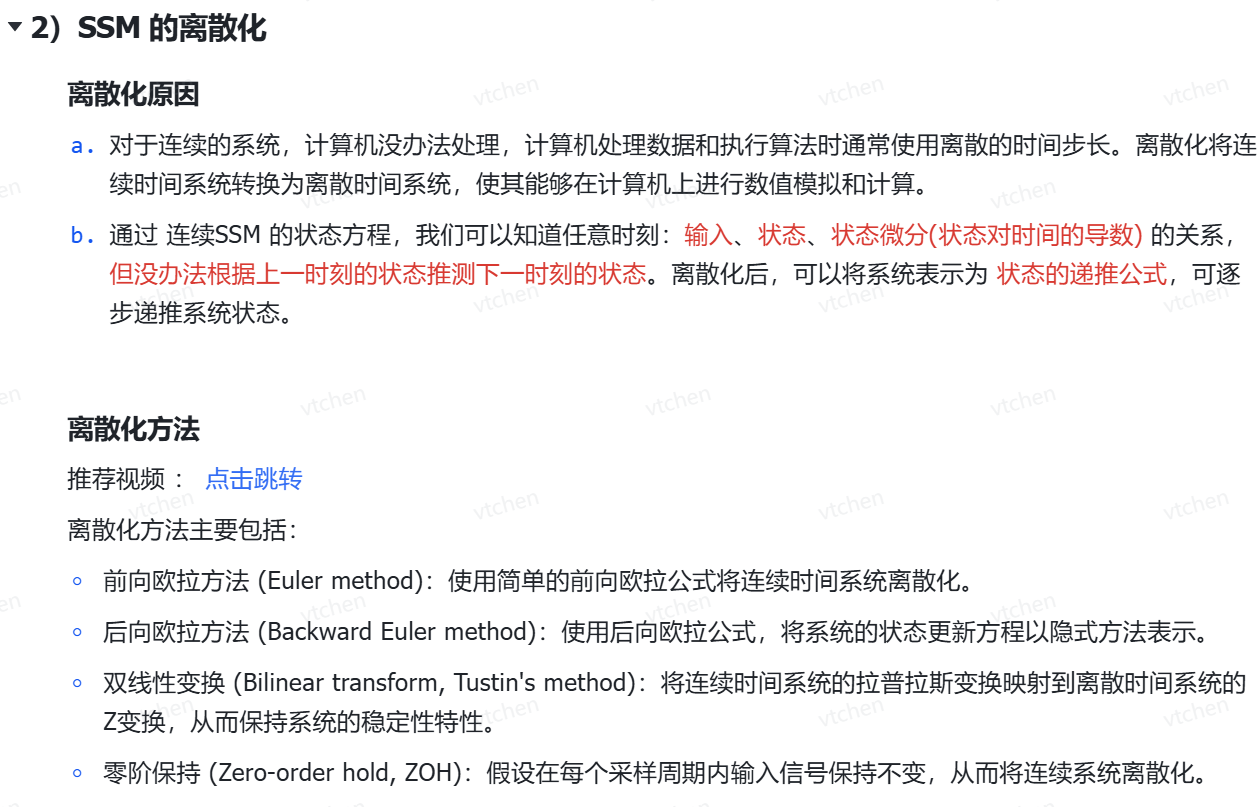

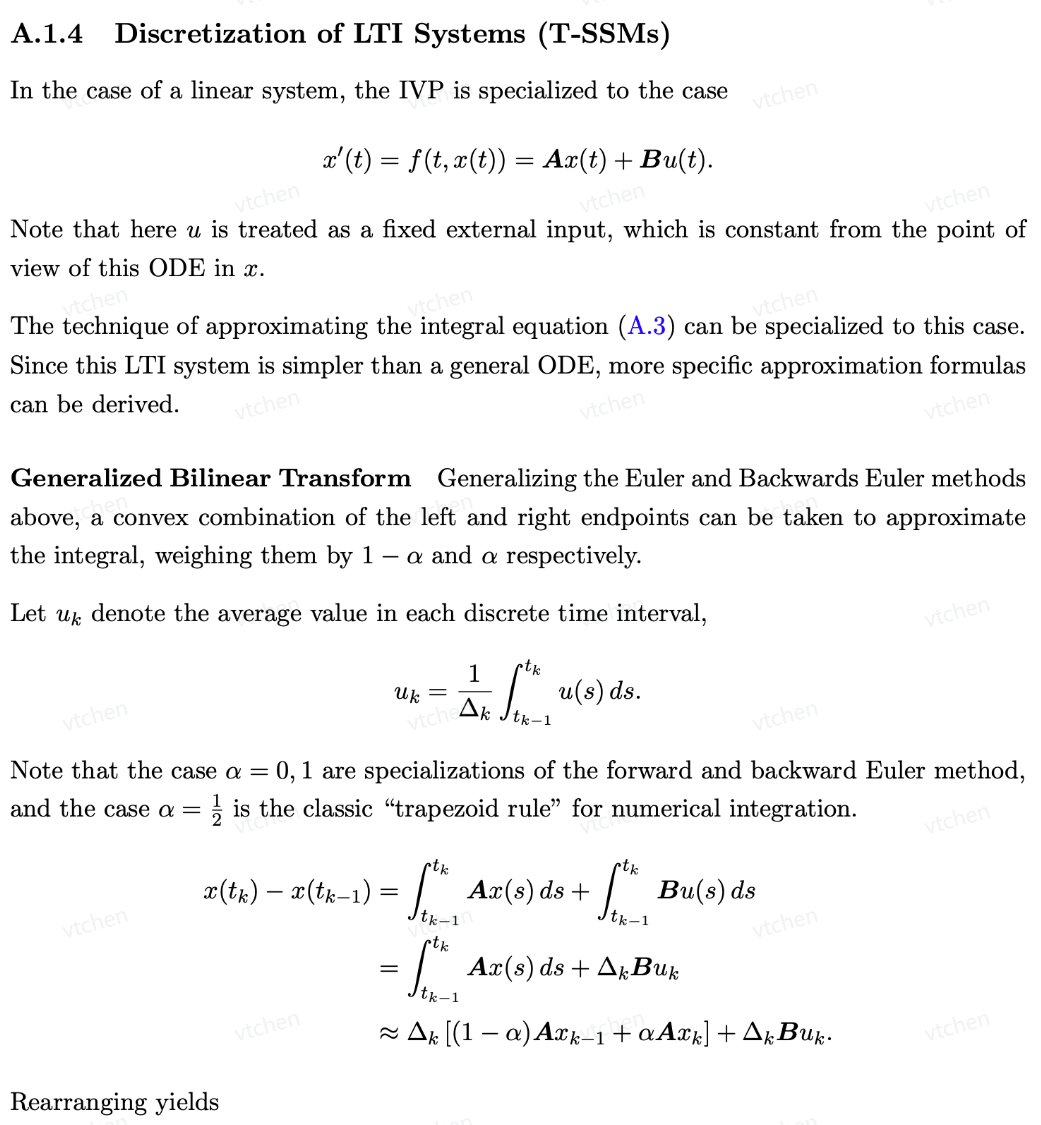
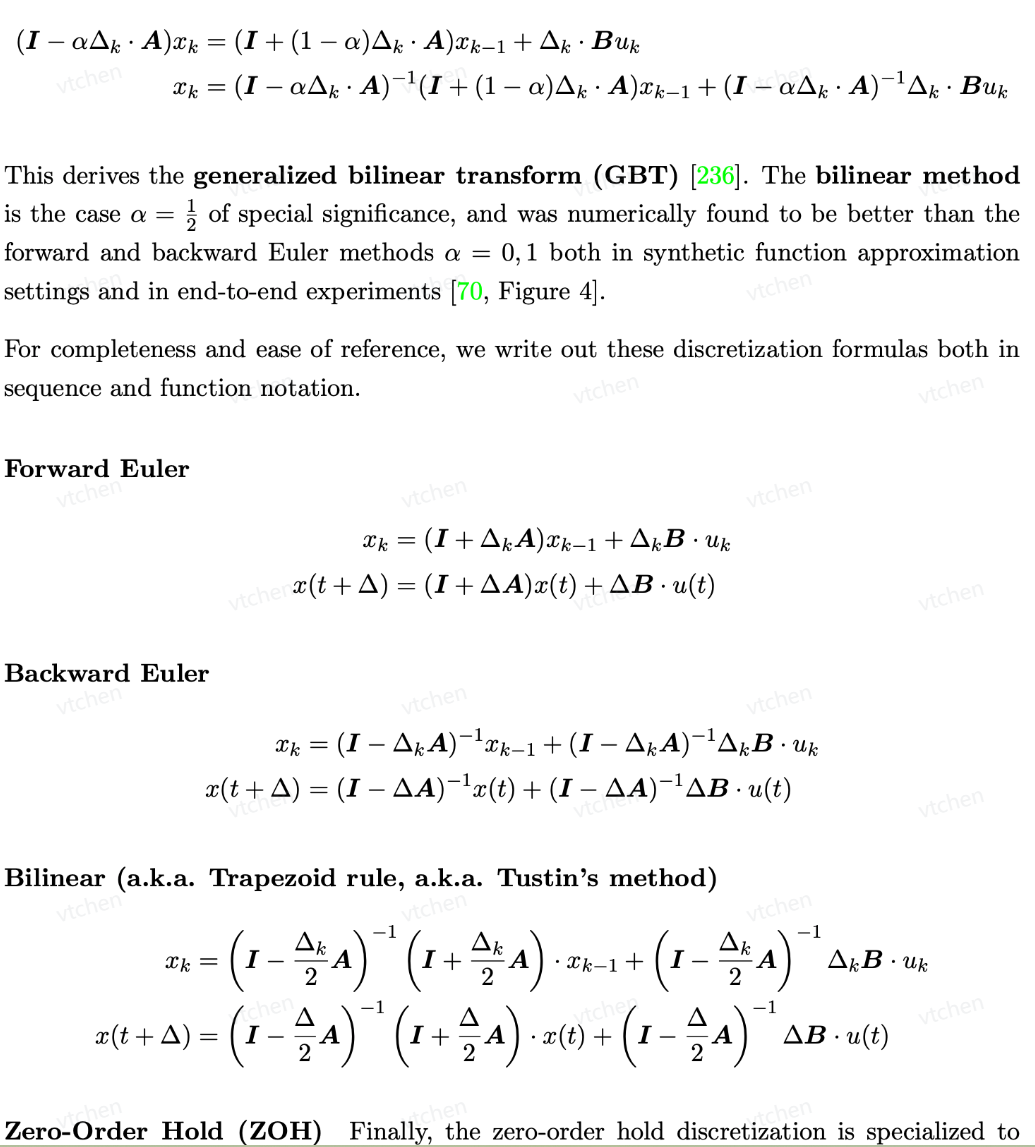
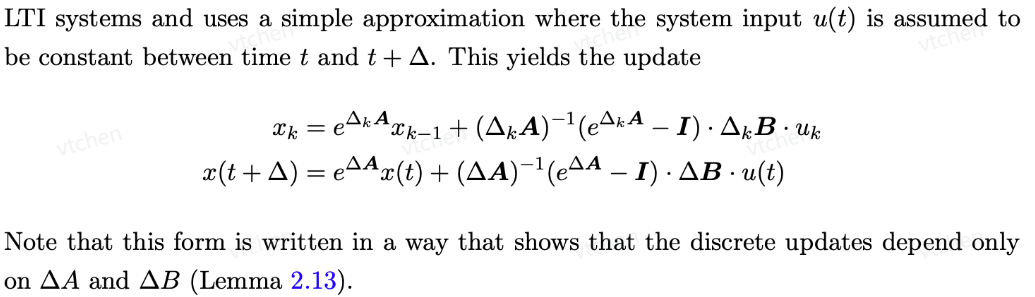

The state space model is defined by this simple equation. It maps a 1-D input signal $u(t)$ to an $N-D$ latent state $x(t)$ before projecting to a 1-D output signal $y(t)$.

$$
\begin{align*}
\bar A &= (I - \Delta /2 A)^{-1} (I + \Delta /2 A) \\
\bar B &= (I - \Delta /2 A)^{-1} \Delta B \\
\bar C &= C \\
\end{align*}
$$


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from celluloid import Camera


def random_SSM(N):
    A = torch.rand(N, N)
    B = torch.rand(N, 1)
    C = torch.rand(1, N)
    return A, B, C


# To discretize the continuous-time SSM, we use the bilinear method, which converts the state matrix 𝐴 into an approximation A. The discrete SSM is


def discretize(A, B, C, step):
    I = torch.eye(A.shape[0])
    BL = torch.inverse(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

$$
\begin{align*}
x_k &= \bar A x_{k-1} + \bar B u_k \\
y_k &= C x_k
\end{align*}
$$

In [ ]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    # 定义一个内部函数来计算每一步的状态和输出
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    outputs = []
    x_k = x0
    # 遍历输入序列，计算每一步的输出并存储
    for u_k in u:
        x_k, y_k = step(x_k, u_k)
        outputs.append(y_k)
    return torch.stack(outputs)


def run_SSM(A, B, C, u):
    # 计算输入序列的长度和状态空间模型的维度
    L = u.shape[0]
    N = A.shape[0]
    # 离散化状态空间模型
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)
    # 调用scan_SSM函数计算输出
    return scan_SSM(Ab, Bb, Cb, u[:, None], torch.zeros(N))[1]

In this example, we consider the forward position $y(t)$ of a mass attached to a wall with a spring. Over time, varying force $u(t)$ is applied to this mass. The system is parameterized by mass $m$, spring stiffness $k$, friction constant $b$. We can relate these with the following differential equation:
$$
m y''(t) = u(t) - b y'(t) - k y(t) 
$$

Rewriting this in matrix form yields an SSM in the following form:


In [ ]:
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    return A, B, C


def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)


def example_ssm():
    ssm = example_mass(k=40, b=5, m=1)
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)
    y = run_SSM(*ssm, torch.tensor(u, dtype=torch.float32))

    # seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k].numpy(), color="blue")
        ax3.boxplot(
            [[y[k].item() - 0.04, y[k].item(), y[k].item() + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line.gif", dpi=150, writer="imagemagick")

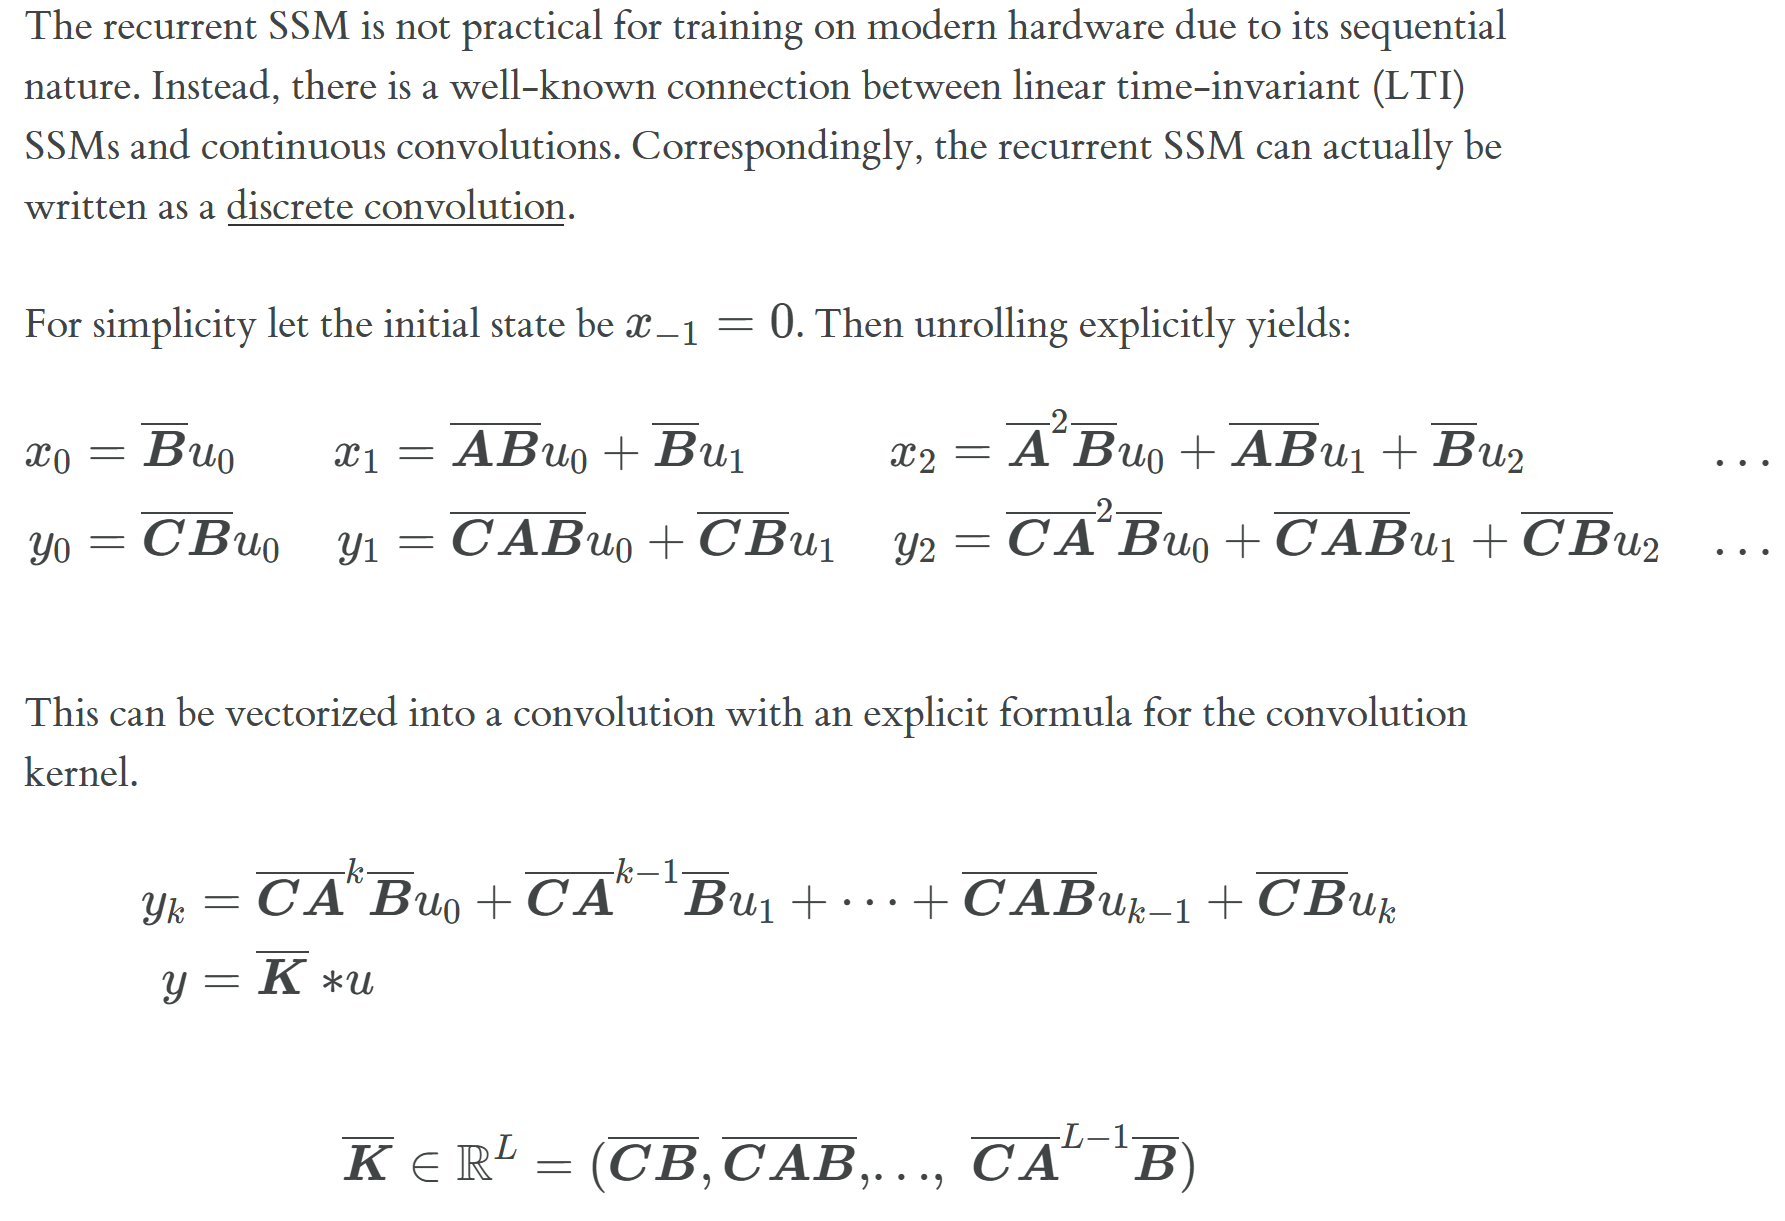


In [ ]:
def K_conv(Ab, Bb, Cb, L):
    return torch.stack([(Cb @ torch.matrix_power(Ab, l) @ Bb).reshape(-1) for l in range(L)])



def causal_convolution(u, K, nofft=False):
    # 如果nofft为True，使用numpy的卷积函数进行因果卷积
    if nofft:
        return np.convolve(u, K, mode="full")[: len(u)]
    else:
        # 确保输入向量u和卷积核K的长度相同
        assert K.shape[0] == u.shape[0]
        # 对输入向量u和卷积核K进行填充并进行快速傅里叶变换
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        # 计算傅里叶变换后的乘积
        out = ud * Kd
        # 进行逆傅里叶变换并截取因果部分
        return np.fft.irfft(out)[: len(u)]

In [ ]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    rng = torch.Generator().manual_seed(0)
    ssm = random_SSM(N)
    u = torch.rand(L, generator=rng)

    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u.numpy(), K_conv(*ssmb, L).numpy())

    # Check
    assert np.allclose(rec.numpy().ravel(), conv.ravel())

In [5]:
import torch
from torch import nn

x = torch.randn(2, 3, 4, 5)
avg_pool = nn.AdaptiveAvgPool2d(1)
avg_pool(x).view(2, 3)

tensor([[ 0.2019, -0.2305, -0.0327],
        [-0.4290, -0.0307, -0.0802]])

In [6]:
x = 5670 - 3* 850
x

3120